In [1]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
#from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    data = data.copy()
    if(isinstance(filters, float)):
        filters = [(0,-1,filters)]
    from scipy.ndimage import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st and sig > 0.0):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data       
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import os
import warnings

# Replace [0] darken old blue #1f77b4 (For Tritanopia blue-green)
# Replace [2] lighten old green #2ca02c (For Deuteranopia red-green)
# Replace [3] darken old red #d62728 (For Deuteranopia red-green)q
colors = ['#1c6ca3', '#ff7f0e', '#2fac2f', '#cb2525', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "stand_p_e_l" : colors[4],
    "stand" : colors[1], # Orange
    "decision_tree" : colors[0],
    "neural_net" : colors[5],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "xg_boost_active" : colors[2],
    "vssm" : "magenta",

    ("stand_hs", False) : colors[4],
    ("stand", False) : colors[1], # Orange
    ("decision_tree", False) : colors[0],
    ("neural_net", False) : colors[5],
    ("random_forest", False) : colors[3],
    ("xg_boost", False) : colors[2],

    ("stand_hs", True) : colors[4],
    ("stand", True) : colors[1], # Orange
    ("decision_tree", True) : colors[0],
    ("neural_net", True) : colors[5],
    ("random_forest", True) : colors[3],
    ("xg_boost", True) : colors[2],
    
    "stand_p" : colors[8],
    "stand_p_e" : colors[6],
    
    "stand_p_e_l_active" : colors[4],
    "stand_p_l" : colors[4],
    "stand_p_e_l_SC" : colors[1],
    "stand_p_e_l_SC_active" : colors[1],
    
    
    #"stand_sl30" : colors[8],
    #"stand_sl40" : colors[9],
    #"stand_sl50" : colors[4],
    
    "stand_dyn" : colors[1], # Orange
    "stand_max" : colors[8],
    "stand_near" : colors[4],
    "stand_w_slip" : colors[3],
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    ("decision_tree", False) : "Decision Tree",
    ("decision_tree", True) : "Decision Tree",
    
    "random_forest" : "Random Forest",
    ("random_forest", False) : "Random Forest",
    ("random_forest", True) : "Random Forest",
    
    "xg_boost" : "XGBoost",
    ("xg_boost", False) : "XGBoost",
    ("xg_boost", True) : "XGBoost",
    
    "stand" : "STAND",
    ("stand", False) : "STAND",
    ("stand", True) : "STAND",
    
    "stand_p_e_l" : "STAND (hier. shrink)",
    ("stand_hs", False) : "STAND (hier. shrink)",
    ("stand_hs", True) : "STAND (hier. shrink)",
    
    "neural_net" : "Neural Net",
    ("neural_net", False) : "Neural Net",
    ("neural_net", True) : "Neural Net",

    "vssm" : "VSSM",
    
}

cond_marker_props = {
    #"stand_p5_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 5}, #(0,5)},
    "stand"          : {"marker" : "^", "markersize" : 6, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    ("stand", False) : {"marker" : "^", "markersize" : 6, "markevery" : 5},
    ("stand", True) : {"marker" : "^", "markersize" : 6, "markevery" : 5},
    "stand_p_e_l"       : {"marker" : "+", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    ("stand_hs", False) : {"marker" : "+", "markersize" : 8, "markevery" : 5},
    ("stand_hs", True) : {"marker" : "+", "markersize" : 8, "markevery" : 5},
    "random_forest"          : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    ("random_forest", False) : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    ("random_forest", True) : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    "decision_tree"          : {"linestyle" : "--"},
    ("decision_tree", False) : {"linestyle" : "--"},
    ("decision_tree", True) : {"linestyle" : "--"},
    "neural_net"          : {"linestyle" : "dashdot"},
    ("neural_net", False) : {"linestyle" : "dashdot"},
    ("neural_net", True) : {"linestyle" : "dashdot"},
    "vssm"          : {"linestyle" : ":"},
    
    "stand_p_e_l_active" : {"linestyle" : "--"},
    "stand_p_e_l_SC_active" : {"linestyle" : "--"},
    "xg_boost_active" : {"linestyle" : "--"},
    
}

def load_stat_sets(file_pattern):
    stat_sets_by_model = {}
    for file_name in glob(file_pattern):
        with open(file_name, 'rb') as f:
            stats_by_model = pickle.load(f)
            for model_name, stats in stats_by_model.items():
                if(model_name == "rand_forest"):
                    model_name = "random_forest"
                if(model_name == "xgboost"):
                    model_name = "xg_boost"
                stats_list = stat_sets_by_model.get(model_name, [])
                stats_list.append(stats)
                stat_sets_by_model[model_name] = stats_list
    return stat_sets_by_model

def aggregate_stat(stat_sets_by_model, stat_name, agg_fn = np.nanmean, filt=None):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        #print(stat_name, stats_list)
        stat_vals = [x[stat_name] for x in stats_list if stat_name in x]
        if(filt):
            filt_name, filt_fn = filt
            filt_vals = [x[filt_name] for x in stats_list if filt_name in x]
            #print(stat_vals)
            #print(filt_vals)
            stat_vals = [(x if filt_fn(f) else np.nan) for x,f in zip(stat_vals, filt_vals)]
        
        if(len(stat_vals) == 0):
            continue
            
        if(isinstance(stat_vals[0], np.ndarray)):
            max_len = max([len(x) for x in stat_vals])
            stat_vals = np.array([np.pad(x, ((0, max_len-len(x))), mode='constant', constant_values=np.nan) for x in stat_vals])
            stat_vals = np.stack(stat_vals)
            
        with warnings.catch_warnings():
            stat_vals = np.array(stat_vals)
            agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan
        
        #if(isinstance(agg, np.ndarray)):
        #    agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out

def aggregate_active_utility(stat_sets_by_model, stat_name, stat_max=1):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        vals = [x[stat_name] for x in stats_list if stat_name in x]
        
        
        active_name = model_name + "_active"
        #print(active_name, active_name in curve_by_model)
        if(active_name in stat_sets_by_model):
            active_stat_list = stat_sets_by_model[active_name]
            a_vals = [x[stat_name] for x in active_stat_list if stat_name in x]
        else:
            continue
            #curve_pairs[model_name] = (curve, curve_by_model[active_name])

        if(len(vals) == 0):
            continue
        #print(model_name)
        
        norm_vals = []
        for v,a in zip(vals, a_vals):
            v = np.array(v)
            a = np.array(a)
            with np.errstate(divide='ignore', invalid='ignore'):
                #print(a-v)
                den = (stat_max-np.min([a,v], axis=0))
                nv = np.where(np.abs(den) > 1e-6, (a-v) / den, 1.0)
                norm_vals.append(nv)
                #print("v:", v)
                #print("a:", a)
                #print("nv:", nv)
            
        with warnings.catch_warnings():
            agg = np.nanmean(np.array(norm_vals), axis=0)
        agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out
        
def plot_title(ax, title):
    if(not ax):
        plt.grid()
        plt.title(title)
        _ax = plt
    else:
        ax.grid()
        ax.set_title(title)
        _ax = ax
    return _ax

def plot_axes(ax, x_lim, y_lim, x_label, y_label):
    if(ax):
        print("AX", ax)
        if(x_lim): ax.set_xlim(*x_lim)
        if(y_lim): ax.set_ylim(*y_lim)
        if(x_label): ax.set_xlabel(x_label)
        if(y_label): ax.set_ylabel(y_label)
    else:
        if(x_lim): plt.xlim(*x_lim)
        if(y_lim): plt.ylim(*y_lim)
        if(x_label): plt.xlabel(x_label)
        if(y_label): plt.ylabel(y_label)

def do_save(save_name):
    if(save_name): 
        os.makedirs("sim_plots", exist_ok=True)
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        #plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
        
def plot_stat(curve_by_model, title=None, skip=[], y_lim=None, x_lim=(-2,102), h_line=None,
              y_label=None, x_label="Number of Examples", save_name=None, show_active=False,
              smooth=2.0, force_legend=False, ax=None):
    
    if(not ax):
        plt.figure(figsize=(7,3.5))
    
    _ax = plot_title(ax, title)

    handles = []
    labels = []
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        h, = _ax.plot(np.arange(1,len(curve)+1), gauss(curve*100, smooth), color=color, 
                 label=label, **marker_props, linewidth=2)
        
        handles.append(h)
        labels.append(label)

    if(ax is None or force_legend):
        _ax.legend(handles,labels, fontsize=10)
    
    
    if(h_line is not None): _ax.hlines(h_line, *x_lim, linestyle='--', color="#999")
    plot_axes(ax, x_lim, y_lim, x_label, y_label)
    do_save(save_name)
    
        #plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    if(not ax): plt.show()

    
def print_stats(stat_sets_by_model, stat_name=None, title=None, big_better=True, index=None):
    title = title if title else stat_name
    
    print(f"{title}:")
    if(stat_name is not None):
        with warnings.catch_warnings():
            if(index is None):
                d = {name : np.nanmean(np.array([x[stat_name] for x in stats if stat_name in x]),axis=0) 
                     for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
            else:
                
                d = {name : np.nanmean(np.array([x[stat_name][index] for x in stats if stat_name in x]),axis=0) 
                     for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
    else:
        d = stat_sets_by_model
            
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (model_name, val) in enumerate(d.items()):
        #when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        print(f"  {model_name}: {pre}{val*100:.2f}%{post}")



CRE Cache Lives Here:  /home/danny/.cache/cre/cre_cache


/home/danny/.alvenv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


unicode_type
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
_stat_sets_by_model = load_stat_sets("sim_saves/*")
stats_vssm = load_stat_sets("vssm/*")
stat_sets_by_model = {**_stat_sets_by_model, **stats_vssm}

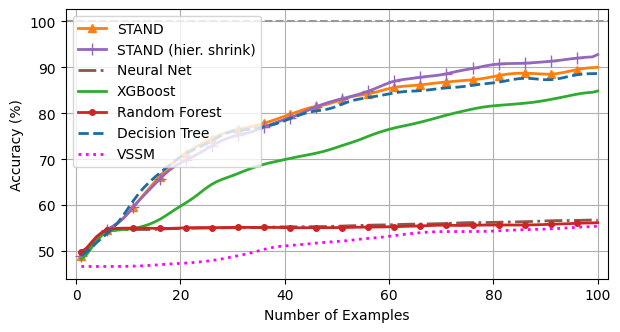

/tmp/ipykernel_6748/3638557320.py:167: RuntimeWarning: Mean of empty slice
  agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan


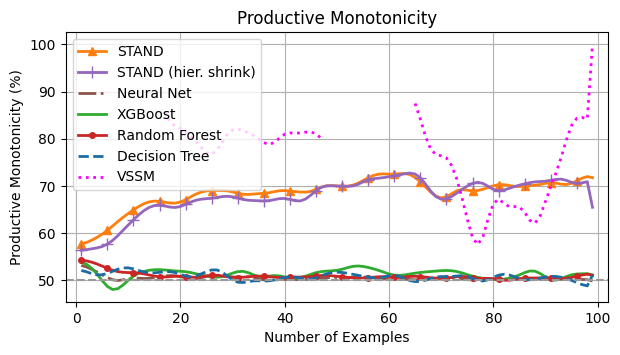

/tmp/ipykernel_6748/3638557320.py:167: RuntimeWarning: Mean of empty slice
  agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan


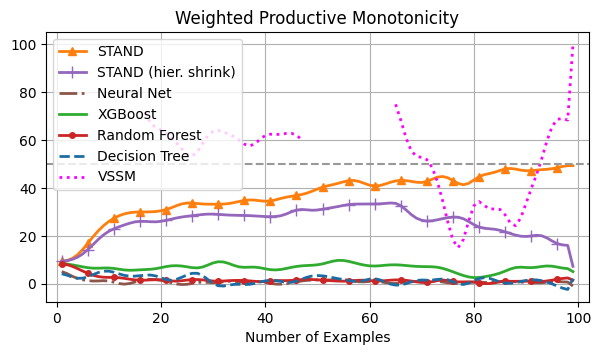

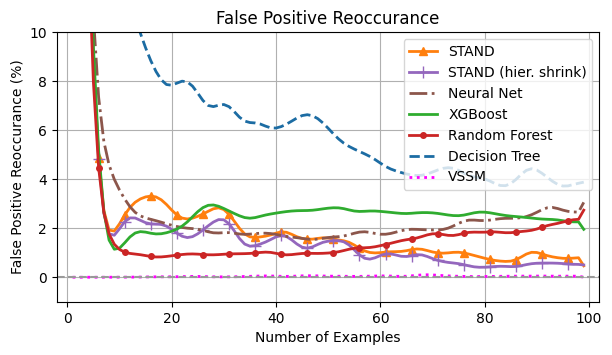

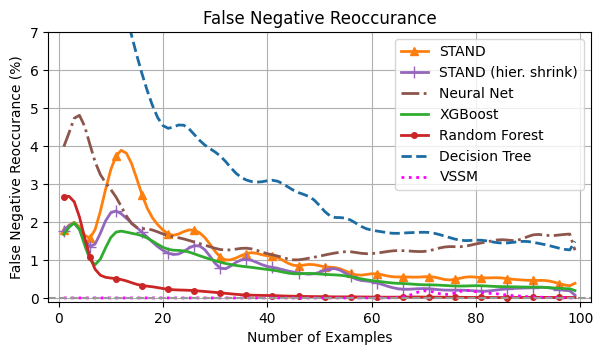

In [3]:
#stat_sets_by_model = load_stat_sets("sim_saves/*")

plot_stat( aggregate_stat(stat_sets_by_model, "accuracies"),
           None, h_line=100, show_active=False, y_label="Accuracy (%)", save_name="acc")
plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot")
plot_stat( aggregate_stat(stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,10), h_line=0, y_label="False Positive Reoccurance (%)", 
          save_name="fp_reoc")
plot_stat(aggregate_stat(stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,7), h_line=0, y_label="False Negative Reoccurance (%)",
          save_name="fn_reoc")

In [4]:
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=20", True, index=19)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=50", True, index=49)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=100", True, index=99)
print()
print_stats(stat_sets_by_model, "total_prod_monot", "Total Productive Monotonicity")
print_stats(stat_sets_by_model, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(stat_sets_by_model, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(stat_sets_by_model, "total_FP_reocc", "Total Omission Reoccurance", False)
print_stats(stat_sets_by_model, "avg_abs_prec_res", "Average Absolute Precision Residual", False)
print()

#stat_sets_w_o_dt = {k:v for k,v in stat_sets_by_model.items() if k != "decision_tree"}
#print_stats(stat_sets_w_o_dt, ("TN_n",(.50, .51)), "Total Precision @55% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.60, .7)), "Total Precision @65% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.70, .8)), "Total Precision @75% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.80, .9)), "Total Precision @85% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.90, .92)), "Total Precision @91% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.92, .94)), "Total Precision @93% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.94, .96)), "Total Precision @95% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.96, .98)), "Total Precision @96% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.98, 1.0)), "Total Precision @97% +/-1%", True)
print_stats(stat_sets_by_model, ("total_precision",(1.0, 1.0)), "Total Precision @100% +/-1%", True)


Total Productive Monotonicity:
  stand: 62.51%
  stand_active: 62.38%
  stand_p_e_l: 60.19%
  stand_p_e_l_active: 60.97%
  neural_net: 50.69%
  neural_net_active: 50.86%
  xg_boost: 53.56%
  xg_boost_active: 53.57%
  random_forest: 51.04%
  random_forest_active: 50.91%
  decision_tree: 52.64%
  vssm: 71.14%
Total Error Reoccurance:
  stand: 1.78%
  stand_active: 2.06%
  stand_p_e_l: 1.44%
  stand_p_e_l_active: 1.97%
  neural_net: 2.38%
  neural_net_active: 1.94%
  xg_boost: 1.95%
  xg_boost_active: 1.66%
  random_forest: 1.17%
  random_forest_active: 3.26%
  decision_tree: 5.33%
  vssm: 0.03%
Total Comission Reoccurance:
  stand: 1.15%
  stand_active: 1.41%
  stand_p_e_l: 0.80%
  stand_p_e_l_active: 1.26%
  neural_net: 1.66%
  neural_net_active: 1.28%
  xg_boost: 0.76%
  xg_boost_active: 0.64%
  random_forest: 0.23%
  random_forest_active: 0.93%
  decision_tree: 3.80%
  vssm: 0.03%
Total Omission Reoccurance:
  stand: 2.56%
  stand_active: 2.83%
  stand_p_e_l: 2.22%
  stand_p_e_l_acti

In [5]:

#DEFAULT_CERT_BINS = [( .5+(.01*(i)), .5+(.01*(i+1)) ) for i in range(50)]+[(1.0,1.0)]
DEFAULT_CERT_BINS = [( .5+(.02*(i)), .5+(.02*(i+1)) ) for i in range(25)]+[(1.0,1.0)]
#DEFAULT_CERT_BINS = [( .0+(.01*(i)), .0+(.01*(i+1)) ) for i in range(100)]+[(1.0,1.0)]
print(DEFAULT_CERT_BINS)

def plot_prec(bin_means, curve_by_model, title=None, skip=[], y_lim=None, x_lim=(49,101), h_line=None,
              line=None, smooth=0.0, ax=None, force_legend=False,
              x_label="Estimated Probability (%)", y_label="True Precision (%)", save_name=None, show_active=False):
    
    if(not ax):
        plt.figure(figsize=(7,3.5))
    _ax = plot_title(ax, title)

    handles = []
    labels = []
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        h = _ax.plot(bin_means*100, curve*100, color=color, 
                 label=label, **marker_props)
        handles.append(h)
        labels.append(label)
        
    if(ax is None or force_legend):
        _ax.legend(handles, labels, fontsize=10)
    
    if(line is not None): _ax.plot([x[0] for x in line], [x[1] for x in line], linestyle='--', color="#999")
    if(h_line is not None): _ax.hlines(h_line, *x_lim, linestyle='--', color="#999")

    
    plot_axes(ax, x_lim, y_lim, x_label, y_label)
    do_save(save_name)
    
    if(not ax): plt.show()

def plot_precision_curve(stat_sets_by_model,**kwargs):
    res_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    prec_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    bin_means = np.empty(len(DEFAULT_CERT_BINS))
    for i, cert_bin in enumerate(DEFAULT_CERT_BINS):
        c_min, c_max = cert_bin
        c_mean = (c_min + c_max) / 2
        c_hrng = (c_max - c_min) / 2
        #print(cert_bin)
        prec = aggregate_stat(stat_sets_by_model, ('total_precision', cert_bin), np.nanmean,
                              (('bin_n', cert_bin), lambda x: x >= 20))
        #TP_n = aggregate_stat(stat_sets_by_model, ('TP_n', cert_bin), np.sum, (()))
        #bin_n = aggregate_stat(stat_sets_by_model, ('bin_n', cert_bin), np.sum)
        #prec = {k:TP_n[k]/bin_n[k] for k in TP_n}    


        bin_means[i] = c_mean
        for k,p in prec.items():
            res_by_model[k][i] = p-c_mean
            prec_by_model[k][i] = p
    
#print(prec_by_model)

    plot_prec(bin_means, prec_by_model, line=[(50,50),(100,100)], **kwargs)

    
_stat_sets_by_model = load_stat_sets("sim_saves/*")
stat_sets_pred_models = {k:v for k,v in _stat_sets_by_model.items() if not any(x in k for x in ["VSSM", "decision_tree"])}

#plot_precision_curve(stat_sets_pred_models,
#                     title="True Precision by Estimated Probability", save_name='prec')


[(0.5, 0.52), (0.52, 0.54), (0.54, 0.56), (0.56, 0.58), (0.58, 0.6), (0.6, 0.62), (0.62, 0.64), (0.64, 0.66), (0.66, 0.6799999999999999), (0.6799999999999999, 0.7), (0.7, 0.72), (0.72, 0.74), (0.74, 0.76), (0.76, 0.78), (0.78, 0.8), (0.8, 0.8200000000000001), (0.8200000000000001, 0.8400000000000001), (0.8400000000000001, 0.86), (0.86, 0.88), (0.88, 0.9), (0.9, 0.9199999999999999), (0.9199999999999999, 0.94), (0.94, 0.96), (0.96, 0.98), (0.98, 1.0), (1.0, 1.0)]


AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


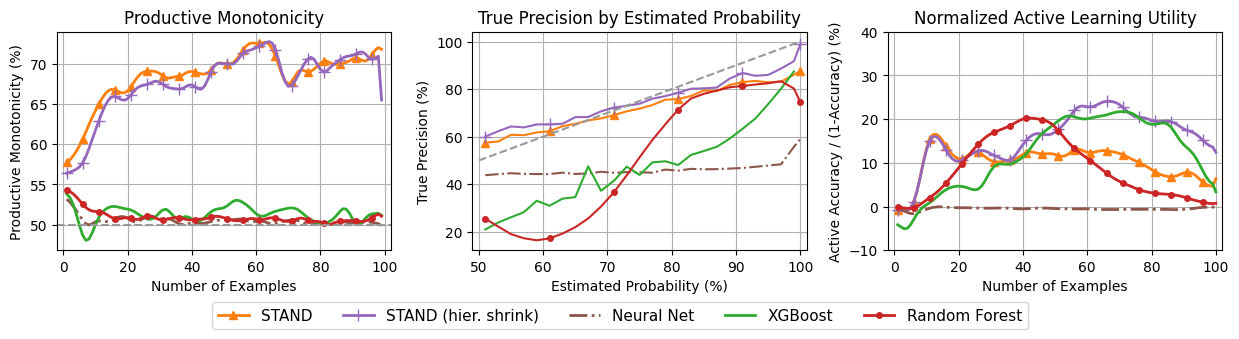

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.2), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

#print(axes)


plot_stat( aggregate_stat(stat_sets_pred_models, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", ax=ax0)

plot_precision_curve(stat_sets_pred_models, ax=ax1,
                     title="True Precision by Estimated Probability")#, save_name='prec')

plot_stat(aggregate_active_utility(stat_sets_pred_models, "accuracies"), ax=ax2,
                  title="Normalized Active Learning Utility", y_label="Active Accuracy / (1-Accuracy) (%)", y_lim=(-10,40))#, save_name="act_lrn")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07), fontsize=11)

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/monot_prec_alu.png", bbox_inches='tight')
plt.show()


#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax1)
#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax2)

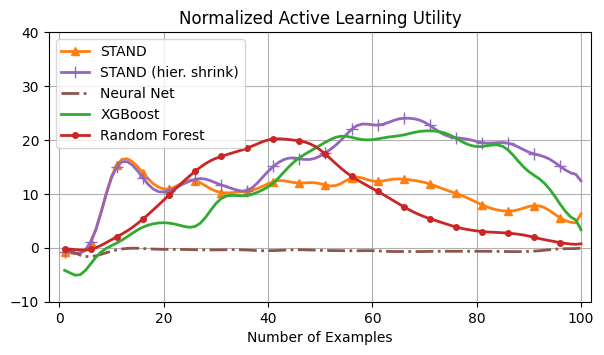

In [7]:
#stat_sets_by_model = load_stat_sets("sim_saves/*")

#plot_active_diff( aggregate_stat(stat_sets_by_model, "accuracies"),
#                  "Active Learning Utility", h_line=100)
plot_stat(aggregate_active_utility(stat_sets_by_model, "accuracies"),
                  "Normalized Active Learning Utility", y_lim=(-10,40), save_name="act_lrn")

(3, 3), (16, 3), (18, 1)
(3, 2), (7, 2), (13, 2), (16, 3), (18, 1), (23, 2), (24, 3)


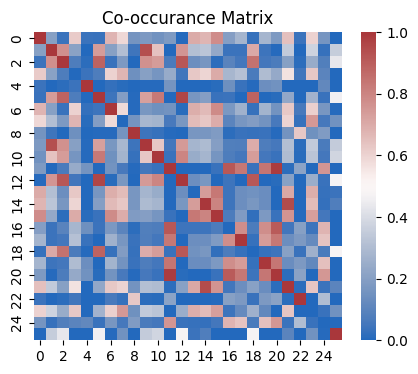

=1 Prop 0.475 0.475
(10, 4), (16, 1)
(1, 2), (15, 1), (20, 1)


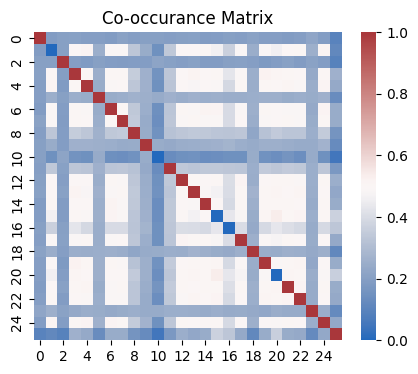

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from gen_synth_conds import gen_synthetic_dnf_data, print_dnf
from numpy.random import poisson
from numba import njit
import seaborn as sns

min_one_possion = lambda x : 1+poisson(x-1)
min_two_possion = lambda x : 2+poisson(x-2)


@njit(cache=True)
def categorical_corr(X):
    N, M = X.shape
    corr = np.zeros((X.shape[1], X.shape[1]), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            corr[i,j] = np.sum(X[:, i] == X[:, j]) / N
    return corr

def zero_true_lits(correlation_matrix, dnf):
    for conj in dnf:
        for lit in conj:
            ind = lit['ind']
            correlation_matrix[ind, ind] = 0.0
            
def plot_co_occurance_matrix(X,y, dnf, save_name=None):
    Xy = np.concatenate([X,y.reshape(-1,1)], axis=1)
    co_occurance_matrix = categorical_corr(Xy)
    zero_true_lits(co_occurance_matrix, dnf)
    plt.figure(figsize=(5, 4))  # Adjust size as needed
    plt.imshow(X, cmap='viridis')

    pallette = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(co_occurance_matrix, annot=False, cmap=pallette)
    plt.title("Co-occurance Matrix")
    if(save_name):
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        
    plt.show()
    
X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=25,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.3,
                          conj_probs=.28,

                          neg_conj_len=lambda : min_two_possion(4),
                          num_neg_conj=100,
                          neg_dupl_lit_prob=0.3,
                          neg_conj_probs=.8,

                          force_same_vals=False)
print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf, save_name="co_occ_struct")


print("=1 Prop", np.sum(y==1)/len(y), np.sum(y==1)/len(y))

X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=25,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.2,
                          conj_probs=.28,

                          #neg_conj_len=lambda : min_two_possion(3),
                          num_neg_conj=0,
                          #neg_dupl_lit_prob=0.1,
                          #neg_conj_probs=.8,

                          force_same_vals=False)

print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf, save_name="co_occ_no_struct")

In [9]:
from training import run_training, train_reps, train_or_load_condition

mc_conditions = {
    ("mc", "stand", True) : {"n_prob": 25, "reps" : 40},
    ("mc", "stand_hs", True) : {"n_prob": 25, "reps" : 40},
    ("mc", "decision_tree", True) : {"n_prob": 25, "reps" : 15},
    ("mc", "random_forest", True) : {"n_prob": 25, "reps" : 20},
    ("mc", "xg_boost", True) : {"n_prob": 25, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

mc_conditions_active = {
    ("mc", "stand", True, True) : {"n_prob": 25, "reps" : 40},
    ("mc", "stand_hs", True, True) : {"n_prob": 25, "reps" : 40},
    #("mc", "decision_tree", True, True) : {"n_prob": 25, "reps" : 15},
    ("mc", "random_forest", True, True) : {"n_prob": 25, "reps" : 10},
    ("mc", "xg_boost", True, True) : {"n_prob": 25, "reps" : 40},
}

frac_conditions = {
    ("frac", "stand", False) : {"n_prob": 25, "reps" : 30},
    ("frac", "stand_hs", False) : {"n_prob": 25, "reps" : 40},
    ("frac", "decision_tree", False) : {"n_prob": 25, "reps" : 40},
    ("frac", "random_forest", False) : {"n_prob": 25, "reps" : 30},
    ("frac", "xg_boost", False) : {"n_prob": 25, "reps" : 30},
}

frac_conditions_active = {
    ("frac", "stand", False, True) : {"n_prob": 25, "reps" : 40},
    ("frac", "stand_hs", False, True) : {"n_prob": 25, "reps" : 40},
    #("frac", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("frac", "random_forest", False, True) : {"n_prob": 25, "reps" : 5},
    ("frac", "xg_boost", False, True) : {"n_prob": 25, "reps" : 40},
}

stat_cache = {}
def stats_by_cond(conditions, stat_name=None, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_prob", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        if(stat_name):
            out[(tup[1], tup[2])] = ret[stat_name][kind]
        else:
            out[(tup[1], tup[2])] = ret
    return out

def stats_at_index_by_cond(conditions, grp, stat_name, index, kind="avg"):
    stats = stats_by_cond(conditions, grp, stat_name, kind)
    stats = {k:v[index] for k,v in stats.items()}
    return stats

def ai2t_plot_precision_curve(stat_sets_by_model,**kwargs):
    #print(list(stat_sets_by_model.keys()))
    res_by_model = {(k[1],k[2]):np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    prec_by_model = {(k[1],k[2]):np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    bin_means = np.empty(len(DEFAULT_CERT_BINS))
    for i, cert_bin in enumerate(DEFAULT_CERT_BINS):
        c_min, c_max = cert_bin
        c_mean = (c_min + c_max) / 2
        c_hrng = (c_max - c_min) / 2
        
        prec = stats_by_cond(stat_sets_by_model, ('total_precision', cert_bin))
        TP_n = stats_by_cond(stat_sets_by_model, ('TP_n', cert_bin))

        bin_means[i] = c_mean
        for k,p in prec.items():
            if(TP_n[k] < 20):
                p = np.nan
            res_by_model[k][i] = p-c_mean
            prec_by_model[k][i] = p
    
    plot_prec(bin_means, prec_by_model, line=[(50,50),(100,100)], **kwargs)


def ai2t_plot_diff(stats, stats_active, stat='accuracy', title=None, 
              x_lim=None, y_lim=None, h_line=None,
              y_label=None, x_label="Number of Problems", ax=None, save_name=None):

    title = title if title else stat
    plt.figure(figsize=(6,4))

    if(not ax):
        plt.figure(figsize=(7,3.5))
    _ax = plot_title(ax, title)
    
    for cond, curve1 in stats_active.items():
        curve0 = stats.get(cond, None)
        if(curve0 is None):
            continue
            
        curve0 = gauss(curve0)
        curve1 = gauss(curve1)
        diff = ((curve1-curve0)/(1-curve0))
        _ax.plot(np.arange(1,len(diff)+1), diff, color=cond_colors.get(cond, "grey"), 
                 label=cond_labels.get(cond, cond), **cond_marker_props.get(cond, {}))
    plt.grid()
    if(not ax):
        plt.legend()
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")

    plot_axes(ax, x_lim, y_lim, x_label, y_label)

    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()



In [10]:
#ai2t_plot_diff(stats_by_cond(frac_conditions, "completeness"), stats_by_cond(frac_conditions_active, "completeness"))
#ai2t_plot_diff(stats_by_cond(mc_conditions, "completeness"), stats_by_cond(mc_conditions_active, "completeness"))

AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


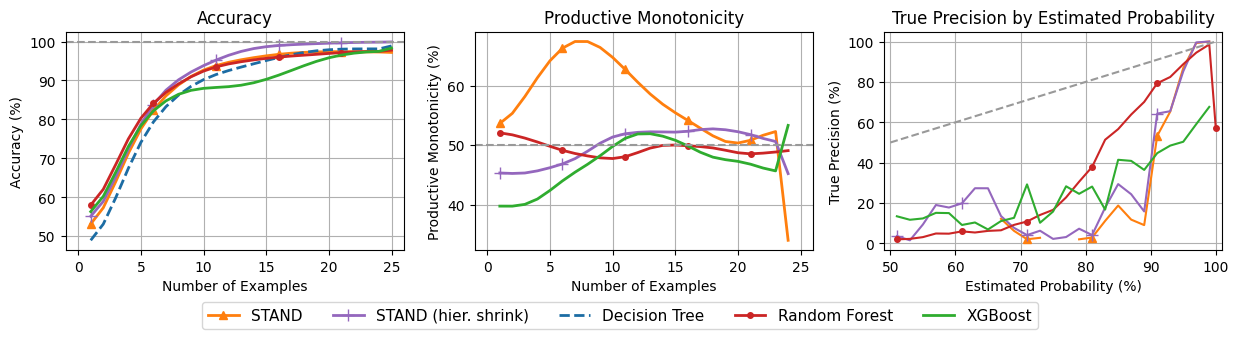

FP Reoccurance:
  ('stand', False): 1.16%
  ('stand_hs', False): 1.35%
  ('decision_tree', False): 0.20%
  ('random_forest', False): 2.33%
  ('xg_boost', False): 3.13%
FN Reoccurance:
  ('stand', False): 0.29%
  ('stand_hs', False): 0.27%
  ('decision_tree', False): 0.44%
  ('random_forest', False): 0.19%
  ('xg_boost', False): 1.10%


In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.2), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           "Accuracy", x_lim = (-1,26), h_line=100, show_active=False, ax=ax0,
           x_label = "Number of Examples", y_label="Accuracy (%)")#, save_name="acc")


frac_conditions_no_pred = {k:v for k,v in frac_conditions.items() if k[1] not in ['decision_tree']}

plot_stat( stats_by_cond(frac_conditions_no_pred, "prod_monot"),
           title="Productive Monotonicity", x_lim = (-1,26), ax=ax1,
           h_line=50, y_label="Productive Monotonicity (%)")

ai2t_plot_precision_curve(frac_conditions_no_pred, ax=ax2,
                     title="True Precision by Estimated Probability")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07), fontsize=11)

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/frac_extra.png", bbox_inches='tight')
plt.show()

print_stats(stats_by_cond(frac_conditions, "total_FP_reocc"), title="FP Reoccurance", big_better=False)
print_stats(stats_by_cond(frac_conditions, "total_FN_reocc"), title="FN Reoccurance", big_better=False)



AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


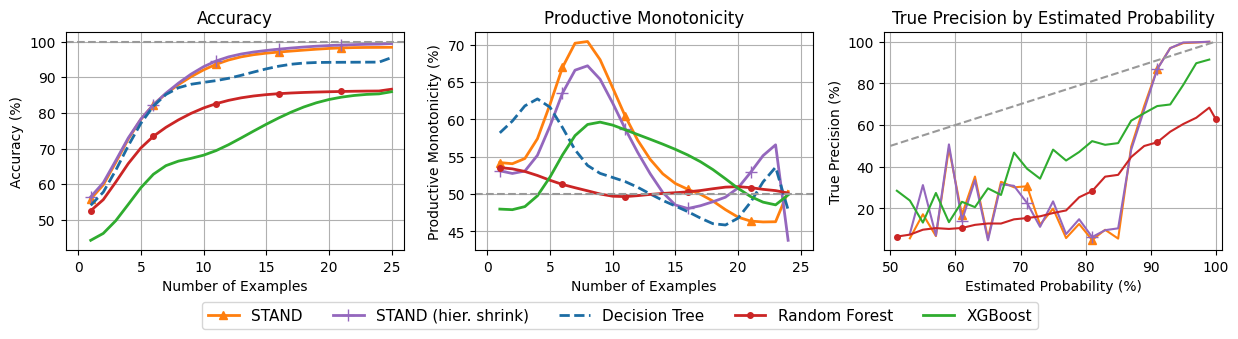

FP Reoccurance:
  ('stand', True): 0.55%
  ('stand_hs', True): 0.67%
  ('decision_tree', True): 0.28%
  ('random_forest', True): 3.20%
  ('xg_boost', True): 4.04%
FN Reoccurance:
  ('stand', True): 0.38%
  ('stand_hs', True): 0.49%
  ('decision_tree', True): 0.97%
  ('random_forest', True): 1.81%
  ('xg_boost', True): 3.85%


In [87]:
fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.2), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           "Accuracy", x_lim = (-1,26), h_line=100, show_active=False, ax=ax0,
           x_label = "Number of Examples", y_label="Accuracy (%)")#, save_name="acc")

plot_stat( stats_by_cond(mc_conditions, "prod_monot"),
           title="Productive Monotonicity", x_lim = (-1,26), ax=ax1,
           h_line=50, y_label="Productive Monotonicity (%)")

ai2t_plot_precision_curve(mc_conditions, ax=ax2,
                     title="True Precision by Estimated Probability")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07), fontsize=11)

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/mc_extra.png", bbox_inches='tight')
plt.show()

print_stats(stats_by_cond(mc_conditions, "total_FP_reocc"), title="FP Reoccurance", big_better=False)
print_stats(stats_by_cond(mc_conditions, "total_FN_reocc"), title="FN Reoccurance", big_better=False)



AX Axes(0.125,0.385;0.348315x0.495)
AX Axes(0.551685,0.66;0.348315x0.22)
AX Axes(0.551685,0.385;0.348315x0.22)
AX Axes(0.551685,0.11;0.348315x0.22)


/tmp/ipykernel_6748/188082082.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


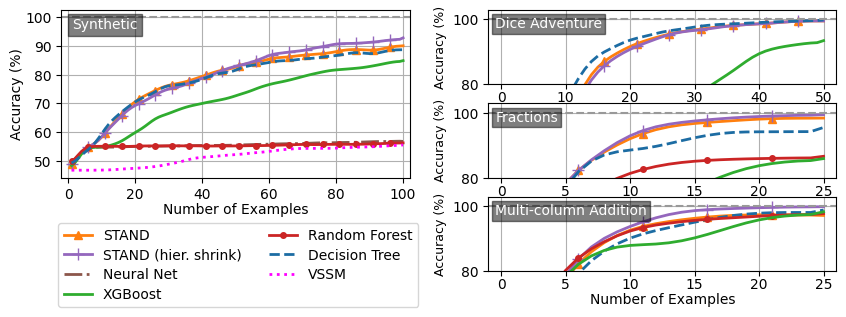

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample images (you can replace these with your actual images)
large_image = np.random.rand(200, 300)
small_images = [np.random.rand(60, 200) for _ in range(3)]

# Create the figure
fig = plt.figure(figsize=(10, 3.4))
gs = gridspec.GridSpec(3, 2, width_ratios=[2, 2], height_ratios=[1, 1, 1], wspace=0.225, hspace=0.25)

# Left: Large image spans all 3 rows
ax_large = plt.subplot(gs[:-1, 0])

ax_large.text(0.03, 0.95, "Synthetic", color='white', fontsize=10,
            ha='left', va='top', transform=ax_large.transAxes,
            bbox=dict(facecolor='black', alpha=0.5, pad=3))

# Right: 3 smaller images
small_ax = []
small_text = ["Dice Adventure", "Fractions", "Multi-column Addition"]
for i in range(3):
    ax = plt.subplot(gs[i, 1])
    small_ax.append(ax)

    ax.text(0.02, 0.9, small_text[i], color='white', fontsize=10,
            ha='left', va='top', transform=ax.transAxes,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax_large.set_ylabel("Accuracy (%)", labelpad=1)

sax0, sax1, sax2 = small_ax

from matplotlib.patches import Patch

plot_stat( aggregate_stat(stat_sets_by_model, "accuracies"),
           None, h_line=100, show_active=False, ax=ax_large, force_legend=False,
           y_label="Accuracy (%)")

da_sets_by_model = load_stat_sets("dice_adv/*")
plot_stat( aggregate_stat(da_sets_by_model, "accuracies"),
           None, h_line=100, x_lim=(-2,52), y_lim=(80,103), show_active=False, ax=sax0, y_label="Accuracy (%)")

plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,103), h_line=100, show_active=False, ax=sax1,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")


plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,103), h_line=100, show_active=False, ax=sax2,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

handles, labels = ax_large.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', ncol=2, bbox_to_anchor=(0.115, -.015), labelspacing=0.4)


sax2.tick_params(axis="x", pad=1)
sax1.tick_params(axis="x", pad=1)
sax0.tick_params(axis="x", pad=1)

sax2.set_ylabel("Accuracy (%)", fontsize=9)
sax1.set_ylabel("Accuracy (%)", fontsize=9)
sax0.set_ylabel("Accuracy (%)", fontsize=9)

sax2.set_xlabel("Number of Examples",labelpad=1)
ax_large.set_xlabel("Number of Examples", labelpad=1)


plt.tight_layout()
plt.savefig(f"sim_plots/acc_all.png", bbox_inches='tight')
plt.show()

AX Axes(0.125,0.11;0.775x0.232892)
AX Axes(0.125,0.734442;0.775x0.145558)
AX Axes(0.125,0.555406;0.775x0.145558)
AX Axes(0.125,0.376371;0.775x0.145558)


/tmp/ipykernel_6748/778280561.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


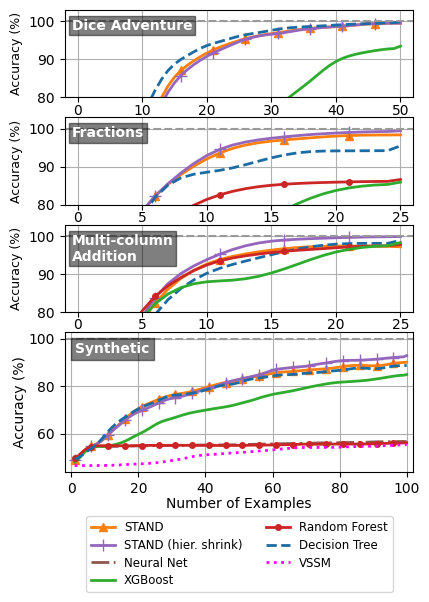

In [73]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample images (you can replace these with your actual images)
large_image = np.random.rand(200, 300)
small_images = [np.random.rand(60, 200) for _ in range(3)]

# Create the figure
fig = plt.figure(figsize=(4.5, 6))
gs = gridspec.GridSpec(4, 1, width_ratios=[1], height_ratios=[1, 1, 1, 1.6], wspace=0.225, hspace=0.2)

# Left: Large image spans all 3 rows
ax_large = plt.subplot(gs[3, 0])

ax_large.text(0.03, 0.93, "Synthetic", color='white', fontsize=10,
            ha='left', va='top', transform=ax_large.transAxes, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.5, pad=3))

# Right: 3 smaller images
small_ax = []
small_text = ["Dice Adventure", "Fractions", "Multi-column\nAddition"]
for i in range(3):
    ax = plt.subplot(gs[i, 0])
    small_ax.append(ax)

    ax.text(0.02, 0.9, small_text[i], color='white', fontsize=10,
            ha='left', va='top', transform=ax.transAxes, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax_large.set_ylabel("Accuracy (%)", labelpad=1)

sax0, sax1, sax2 = small_ax

from matplotlib.patches import Patch

plot_stat( aggregate_stat(stat_sets_by_model, "accuracies"),
           None, h_line=100, show_active=False, ax=ax_large, force_legend=False,
           y_label="Accuracy (%)")

da_sets_by_model = load_stat_sets("dice_adv/*")
plot_stat( aggregate_stat(da_sets_by_model, "accuracies"),
           None, h_line=100, x_lim=(-2,52), y_lim=(80,103), x_label="", show_active=False, ax=sax0, y_label="Accuracy (%)")

plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,103), h_line=100, show_active=False, ax=sax1,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,103), h_line=100, show_active=False, ax=sax2,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

handles, labels = ax_large.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', ncol=2, bbox_to_anchor=(0.16, -.10), fontsize=8.5, labelspacing=0.4)


sax2.tick_params(axis="x", pad=1)
sax1.tick_params(axis="x", pad=1)
sax0.tick_params(axis="x", pad=1)

sax2.set_ylabel("Accuracy (%)", fontsize=9)
sax1.set_ylabel("Accuracy (%)", fontsize=9)
sax0.set_ylabel("Accuracy (%)", fontsize=9)

#sax2.set_xlabel("Number of Examples",labelpad=1)
ax_large.set_xlabel("Number of Examples", labelpad=1)


plt.tight_layout()
plt.savefig(f"sim_plots/acc_all_vert.png", bbox_inches='tight')
plt.show()

AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


/tmp/ipykernel_6748/3638557320.py:167: RuntimeWarning: Mean of empty slice
  agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan


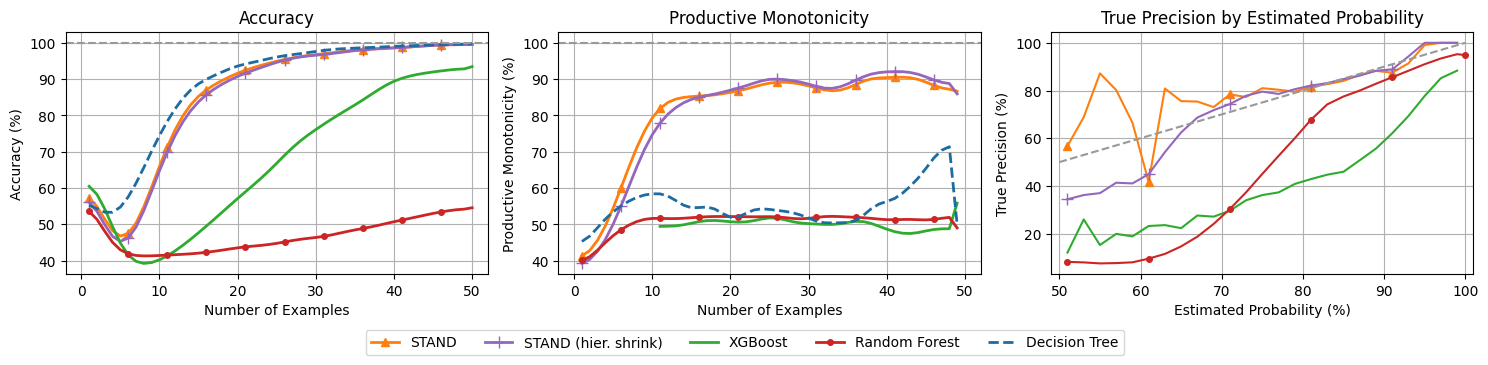

Total FP Reoccurance:
  stand: 2.29%
  stand_p_e_l: 2.32%
  xg_boost: 3.88%
  random_forest: 7.64%
  decision_tree: 5.69%
Total FN Reoccurance:
  stand: 0.38%
  stand_p_e_l: 0.32%
  xg_boost: 0.72%
  random_forest: 0.54%
  decision_tree: 2.35%


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

plot_stat( aggregate_stat(da_sets_by_model, "accuracies"), x_lim=(-2, 52),
           title="Accuracy", h_line=100, show_active=False, ax=ax0, y_label="Accuracy (%)")

plot_stat( aggregate_stat(da_sets_by_model, "prod_monot"), x_lim=(-2, 52),
           title="Productive Monotonicity", h_line=100, show_active=False, ax=ax1, force_legend=False,
           y_label="Productive Monotonicity (%)")

plot_precision_curve(da_sets_by_model, ax=ax2, 
                     title="True Precision by Estimated Probability")

#plot_stat(aggregate_active_utility(stat_sets_pred_models, "accuracies"), ax=ax2,
#                  title="Normalized Active Learning Utility", y_label="Active Accuracy / (1-Accuracy) (%)", y_lim=(-10,40))#, save_name="act_lrn")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/dice_adv.png", bbox_inches='tight')
plt.show()

print_stats(da_sets_by_model, "total_FP_reocc", "Total FP Reoccurance", False)
print_stats(da_sets_by_model, "total_FN_reocc", "Total FN Reoccurance", False)


In [16]:
cond_colors = {
    **cond_colors,
    "stand_p00_e_l" : colors[1],
    "stand_p05_e_l" : colors[2],
    "stand_p1_e_l" : colors[3],
    "stand_p5_e_l" : colors[9],
    "stand_p10_e_l" : colors[5],
    "stand_p25_e_l" : colors[6],
    "stand_p50_e_l" : colors[4],
    "stand_p100_e_l" : colors[8],
    
    "stand_p_e00_l" : colors[1],
    "stand_p_e05_l" : colors[2],
    "stand_p_e1_l" : colors[3],
    "stand_p_e5_l" : colors[9],
    "stand_p_e10_l" : colors[5],
    "stand_p_e25_l" : colors[6],
    "stand_p_e50_l" : colors[8],
    "stand_p_e100_l" : colors[4],

    "stand_p_e_l00" : colors[1],
    "stand_p_e_l05" : colors[2],
    "stand_p_e_l1" : colors[3],
    "stand_p_e_l5" : colors[9],
    "stand_p_e_l10" : colors[5],
    "stand_p_e_l25" : colors[6],
    "stand_p_e_l50" : colors[8],
    "stand_p_e_l100" : colors[4],
    
    "stand_sl0" : colors[1],
    "stand_sl5" : colors[4],
    "stand_sl10" : colors[5],
    "stand_sl15" : colors[9],
    "stand_sl20" : colors[6],
    "stand_sl25" : colors[8],
}

cond_marker_props = {
    **cond_marker_props,
    "stand_p00_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 10},
    "stand_p05_e_l" : {"linestyle" : ":"},
    "stand_p1_e_l" : {"linestyle" : ":"},
    "stand_p5_e_l" : {"linestyle" : ":"},
    "stand_p10_e_l" : {"linestyle" : ":"},
    "stand_p25_e_l" : {"linestyle" : ":"},
    "stand_p50_e_l" : {"marker" : "o", "markersize" : 4, "markevery" : 10},
    "stand_p100_e_l" : {"marker" : "o", "markersize" : 4, "markevery" : 10},

    "stand_p_e00_l" : {"marker" : "^", "markersize" : 6, "markevery" : 10},
    "stand_p_e05_l" : {"linestyle" : ":"},
    "stand_p_e1_l" : {"linestyle" : ":"},
    "stand_p_e5_l" : {"linestyle" : ":"},
    "stand_p_e10_l" : {"linestyle" : ":"},
    "stand_p_e25_l" : {"linestyle" : ":"},
    "stand_p_e50_l" : {"linestyle" : ":"},
    "stand_p_e100_l" : {"marker" : "o", "markersize" : 4, "markevery" : 10},

    "stand_p_e_l00" : {"marker" : "^", "markersize" : 6, "markevery" : 10},
    "stand_p_e_l05" : {"linestyle" : ":"},
    "stand_p_e_l1" : {"linestyle" : ":"},
    "stand_p_e_l5" : {"linestyle" : ":"},
    "stand_p_e_l10" : {"linestyle" : ":"},
    "stand_p_e_l25" : {"linestyle" : ":"},
    "stand_p_e_l50" : {"linestyle" : ":"},
    "stand_p_e_l100" : {"marker" : "o", "markersize" : 4, "markevery" : 10},
}

cond_labels = {
    **cond_labels,
    "stand_p00_e_l" : "$\lambda_p=0.0$",
    "stand_p05_e_l" : "$\lambda_p=0.5$",
    "stand_p1_e_l" : "$\lambda_p=1.0$",
    "stand_p5_e_l" : "$\lambda_p=5.0$",
    "stand_p10_e_l" : "$\lambda_p=10.0$",
    "stand_p25_e_l" : "$\lambda_p=25.0$",
    "stand_p50_e_l" : "$\lambda_p=50.0$",
    "stand_p100_e_l" : "$\lambda_p=100.0$",
    
    "stand_p_e00_l" : "$\lambda_s=0.0$",
    "stand_p_e05_l" : "$\lambda_s=0.5$",
    "stand_p_e1_l" : "$\lambda_s=1.0$",
    "stand_p_e5_l" : "$\lambda_s=5.0$",
    "stand_p_e10_l" : "$\lambda_s=10.0$",
    "stand_p_e25_l" : "$\lambda_s=25.0$",
    "stand_p_e50_l" : "$\lambda_s=50.0$",
    "stand_p_e100_l" : "$\lambda_s=100.0$",

    "stand_p_e_l00" : "$\lambda_n=0.0$",
    "stand_p_e_l05" : "$\lambda_n=0.5$",
    "stand_p_e_l1" : "$\lambda_n=1.0$",
    "stand_p_e_l5" : "$\lambda_n=5.0$",
    "stand_p_e_l10" : "$\lambda_n=10.0$",
    "stand_p_e_l25" : "$\lambda_n=25.0$",
    "stand_p_e_l50" : "$\lambda_n=50.0$",
    "stand_p_e_l100" : "$\lambda_n=100.0$",
}

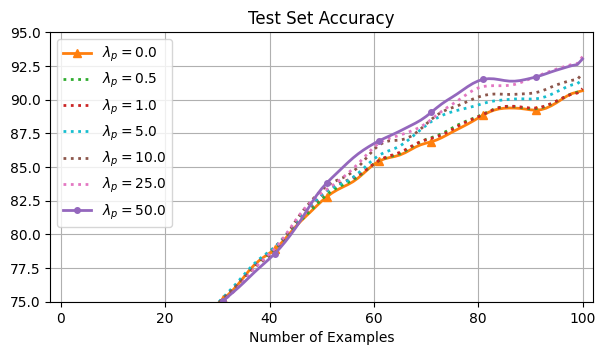

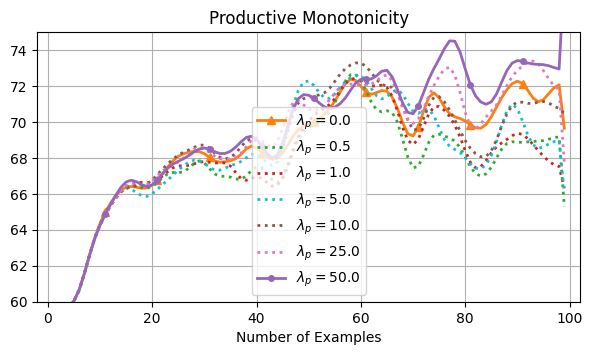

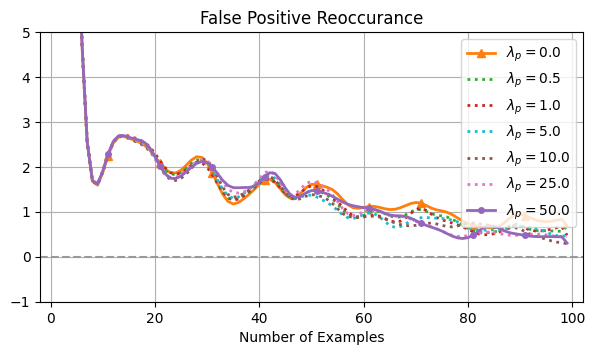

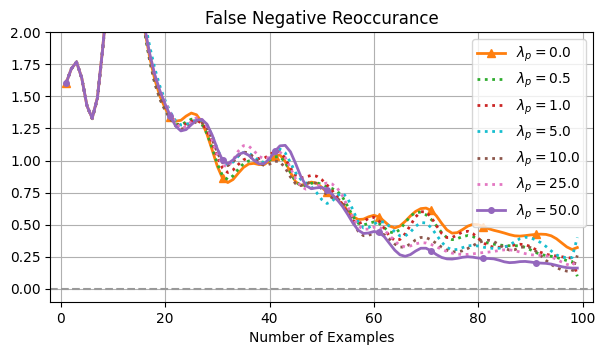

/tmp/ipykernel_6748/4067654260.py:28: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _ax.legend(handles, labels, fontsize=10)


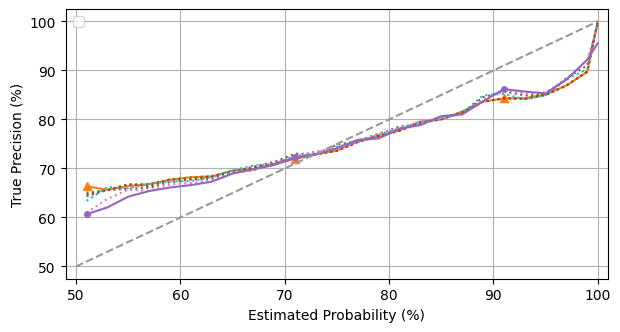

In [17]:
ph_stat_sets_by_model = load_stat_sets("p_hyper/*")

plot_stat( aggregate_stat(ph_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False, y_lim=(75, 95))
plot_stat( aggregate_stat(ph_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_lim=(60, 75))
#plot_stat( aggregate_stat(ph_stat_sets_by_model, "w_prod_monot"),
#           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0)
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0)
plot_precision_curve(ph_stat_sets_by_model)

AX Axes(0.125,0.567838;0.221429x0.312162)
AX Axes(0.401786,0.567838;0.221429x0.312162)
AX Axes(0.125,0.11;0.221429x0.312162)
AX Axes(0.401786,0.11;0.221429x0.312162)
AX Axes(0.678571,0.11;0.221429x0.541081)


/tmp/ipykernel_6748/3062286989.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


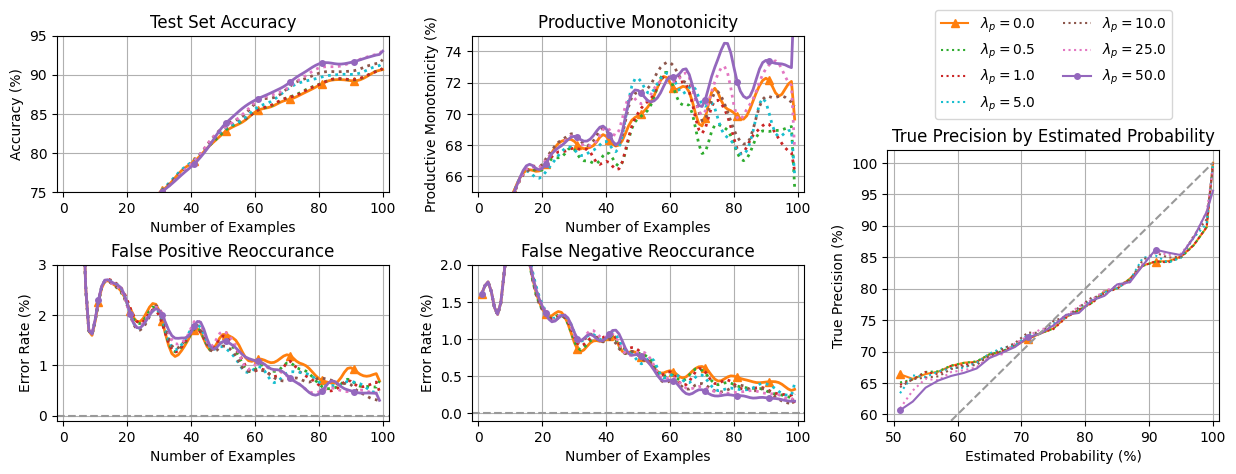

In [18]:
gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1])

fig = plt.figure(figsize=(15, 5))
#fig, axes = plt.subplots(4, 3, figsize=(15, 5), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.25, hspace=1.75) 
#(ax0,ax1,ax2),(ax3,ax4,ax5) = axes

ax0 = fig.add_subplot(gs[0:2, 0])  
ax1 = fig.add_subplot(gs[0:2, 1])  
ax2 = fig.add_subplot(gs[0:2, 2])  
ax3 = fig.add_subplot(gs[2:4, 0]) 
ax4 = fig.add_subplot(gs[2:4, 1]) 
ax5 = fig.add_subplot(gs[1:4, 2]) 


plot_stat( aggregate_stat(ph_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", ax=ax0, h_line=100, show_active=False, y_lim=(75, 95), y_label="Accuracy (%)")
plot_stat( aggregate_stat(ph_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", ax=ax1, h_line=50, y_lim=(65, 75), y_label="Productive Monotonicity (%)")
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", ax=ax3, y_lim=(-.1,3), h_line=0, y_label="Error Rate (%)")
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", ax=ax4, y_lim=(-.1,2), h_line=0, y_label="Error Rate (%)")
plot_precision_curve(ph_stat_sets_by_model, y_lim=(59,102), title="True Precision by Estimated Probability", ax=ax5)
ax2.set_visible(False) 

ax5.legend(loc='lower center', bbox_to_anchor=(0.5, 1.09), ncol=2, fontsize=10)

fig.tight_layout()
plt.savefig(f"sim_plots/p_hyper.png", bbox_inches='tight')
plt.show()


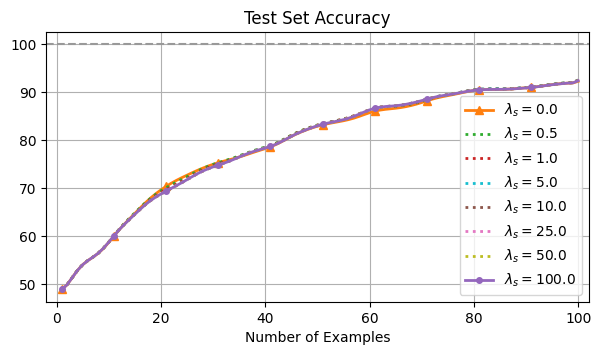

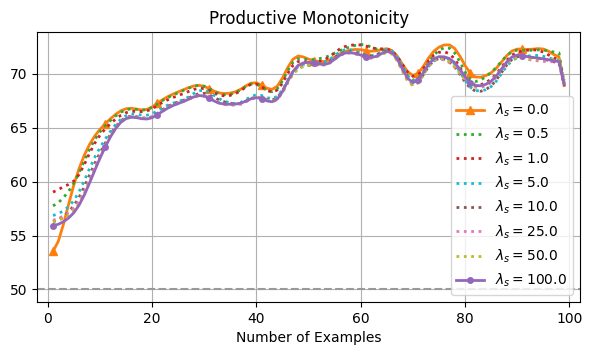

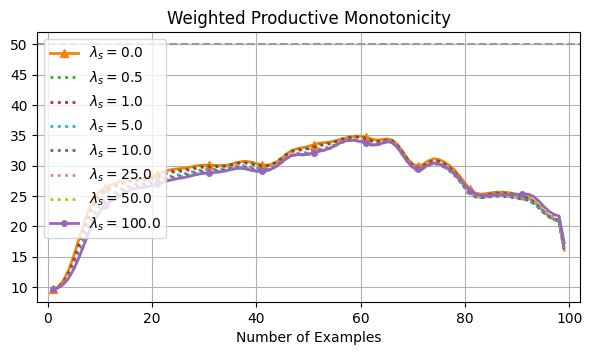

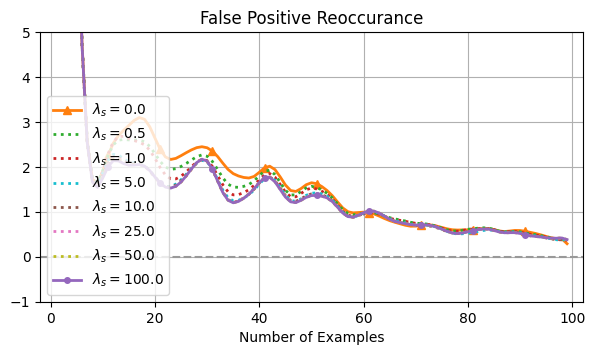

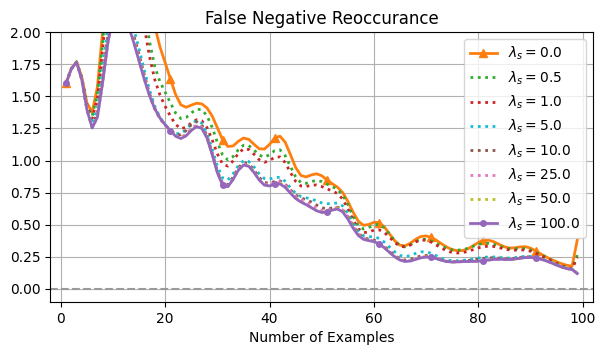

/tmp/ipykernel_6748/4067654260.py:28: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _ax.legend(handles, labels, fontsize=10)


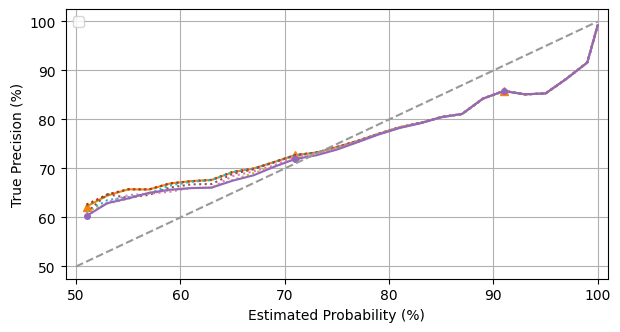

In [19]:
eh_stat_sets_by_model = load_stat_sets("e_hyper/*")

plot_stat( aggregate_stat(eh_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0)
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0)
plot_precision_curve(eh_stat_sets_by_model)

AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


<Figure size 1500x500 with 0 Axes>

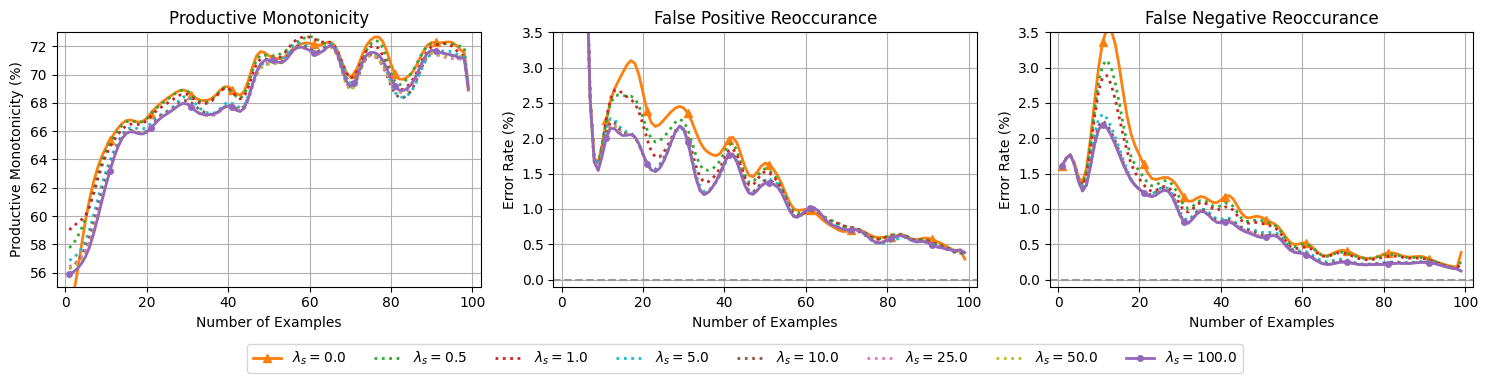

In [20]:
#gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1])

fig = plt.figure(figsize=(15, 5))
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
#plt.subplots_adjust(wspace=0.25, hspace=1.75) 
(ax0,ax1,ax2) = axes

#plot_stat( aggregate_stat(eh_stat_sets_by_model, "accuracies"),
#           "Test Set Accuracy", ax=ax0, h_line=100, show_active=False, y_lim=(75, 95), y_label="Accuracy (%)")
plot_stat( aggregate_stat(eh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", ax=ax0, h_line=50, y_lim=(55, 73), y_label="Productive Monotonicity (%)")
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", ax=ax1, y_lim=(-.1,3.5), h_line=0,  y_label="Error Rate (%)")
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", ax=ax2, y_lim=(-.1,3.5), h_line=0,  y_label="Error Rate (%)")
#plot_precision_curve(eh_stat_sets_by_model, y_lim=(59,102), title="True Precision by Estimated Probability", ax=ax5)
#ax2.set_visible(False) 

handles, labels = ax0.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.1))

#ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.09), ncol=8, fontsize=10)

fig.tight_layout()
plt.savefig(f"sim_plots/s_hyper.png", bbox_inches='tight')
plt.show()


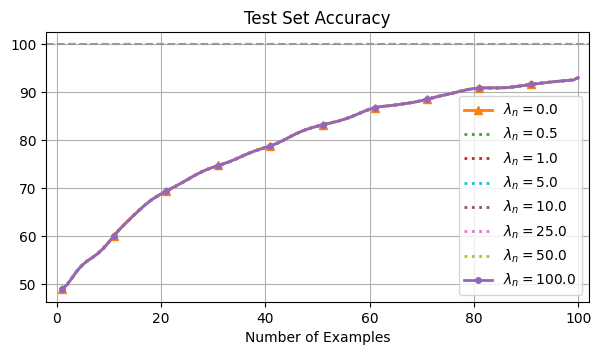

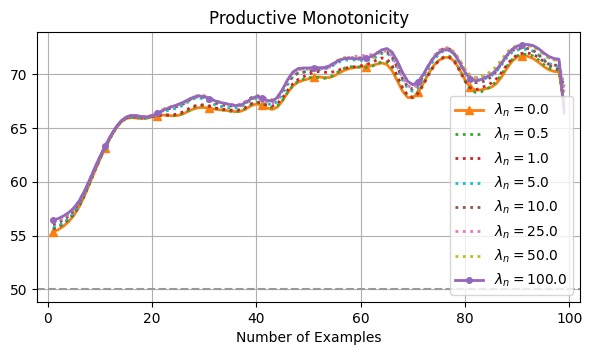

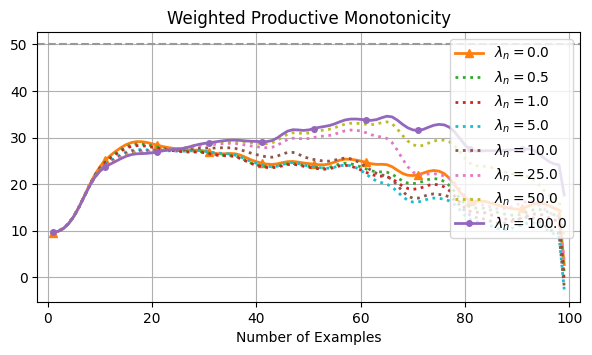

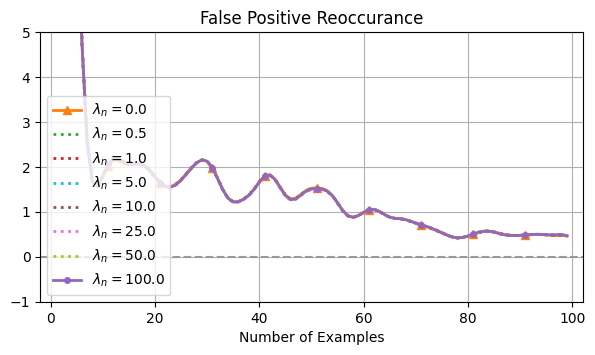

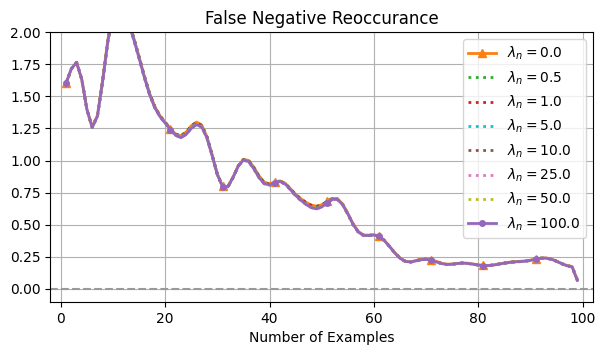

/tmp/ipykernel_6748/4067654260.py:28: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _ax.legend(handles, labels, fontsize=10)


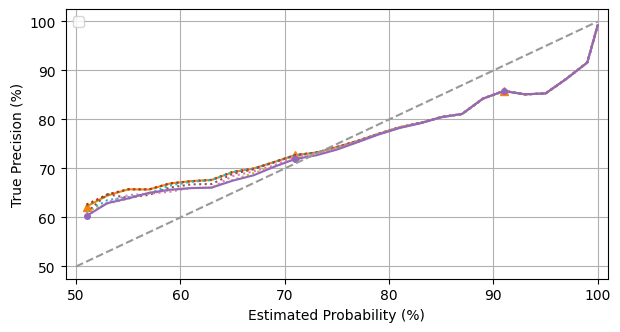

In [21]:
lh_stat_sets_by_model = load_stat_sets("l_hyper/*")

plot_stat( aggregate_stat(lh_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(lh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(lh_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(lh_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0, save_name="mc_oms")
plot_stat(aggregate_stat(lh_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0, save_name="frac_oms")
plot_precision_curve(eh_stat_sets_by_model)

AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)


<Figure size 1500x500 with 0 Axes>

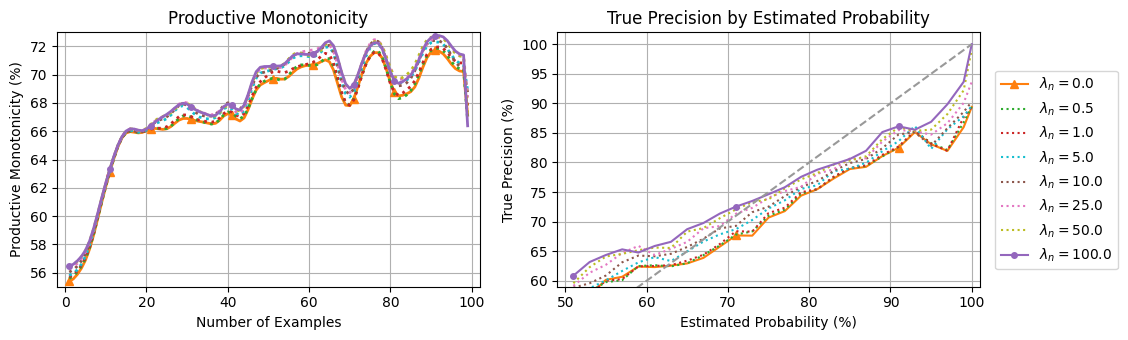

In [22]:
#gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1])

fig = plt.figure(figsize=(15, 5))
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
#plt.subplots_adjust(wspace=0.25, hspace=1.75) 
(ax0,ax1,ax2) = axes

#plot_stat( aggregate_stat(eh_stat_sets_by_model, "accuracies"),
#           "Test Set Accuracy", ax=ax0, h_line=100, show_active=False, y_lim=(75, 95), y_label="Accuracy (%)")
plot_stat( aggregate_stat(lh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", ax=ax0, h_line=50, y_lim=(55, 73), y_label="Productive Monotonicity (%)")
#plot_stat(aggregate_stat(eh_stat_sets_by_model, "FP_reocc"),
#          "False Positive Reoccurance", ax=ax1, y_lim=(-.1,3.5), h_line=0, save_name="mc_oms", y_label="Error Rate (%)")
#plot_stat(aggregate_stat(eh_stat_sets_by_model, "FN_reocc"),
#          "False Negative Reoccurance", ax=ax2, y_lim=(-.1,3.5), h_line=0, save_name="frac_oms", y_label="Error Rate (%)")
plot_precision_curve(lh_stat_sets_by_model, y_lim=(59,102), title="True Precision by Estimated Probability", ax=ax1)
ax2.set_visible(False) 

handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='center right', ncol=8, bbox_to_anchor=(0.5, -0.1))
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(.662, 0.5))

#ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.09), ncol=8, fontsize=10)

fig.tight_layout()
plt.savefig(f"sim_plots/n_hyper.png", bbox_inches='tight')
plt.show()
